## Import libraries

In [42]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, Bidirectional, LSTM, 
    Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, 
    Attention, MultiHeadAttention, Input, GRU)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from nltk import FreqDist

## Load data

In [15]:
df = pd.read_csv("./Data/IMDB Dataset SPANISH.csv")
df.head()

,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   50000 non-null  int64 
 1   review_en    50000 non-null  object
 2   review_es    50000 non-null  object
 3   sentiment    50000 non-null  object
 4   sentimiento  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [17]:
df = df[['review_en', 'sentiment']]
df.head()

,review_en,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Process data 

In [18]:
def cleaning_sentence_en(sentence):
    sentence = re.sub(r'[^a-zA-Z\s\'-]', '', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [19]:
def tokenize_sentences(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        tokenized_sentences.append(sentence.split())
    return tokenized_sentences

In [20]:
def vectorice_sentences(sentences, indexes):
    vectoriced_sentences = []
    for sentence in sentences:
        vectoriced_sentence = []
        for word in sentence:
            if word in indexes:
                vectoriced_sentence.append(indexes[word])
            else:
                vectoriced_sentence.append(0)
        vectoriced_sentences.append(vectoriced_sentence)
    return vectoriced_sentences

In [21]:
df['review_en'] = df['review_en'].apply(cleaning_sentence_en)
tokenized_sentences = tokenize_sentences(df['review_en'])

## Word Cloud

In [22]:
corpus = ' '.join(df['review_en'].to_list())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

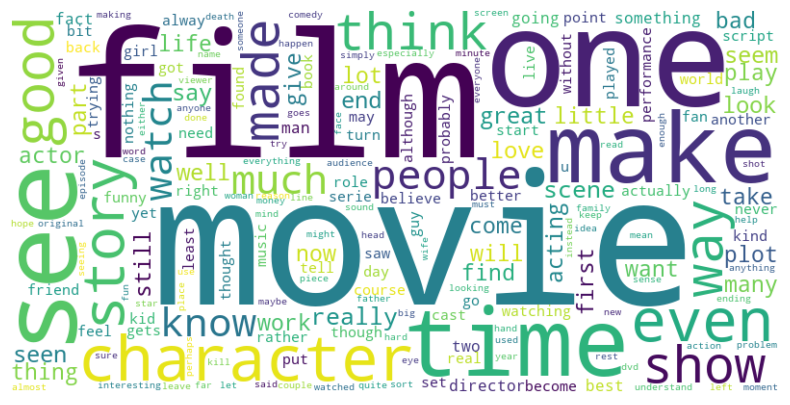

In [23]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Top words

In [24]:
words = []
for sentence in tokenized_sentences:
    words.extend(sentence)
frequency = FreqDist(words)
top_20 = frequency.most_common(20)
words, freq = zip(*top_20)

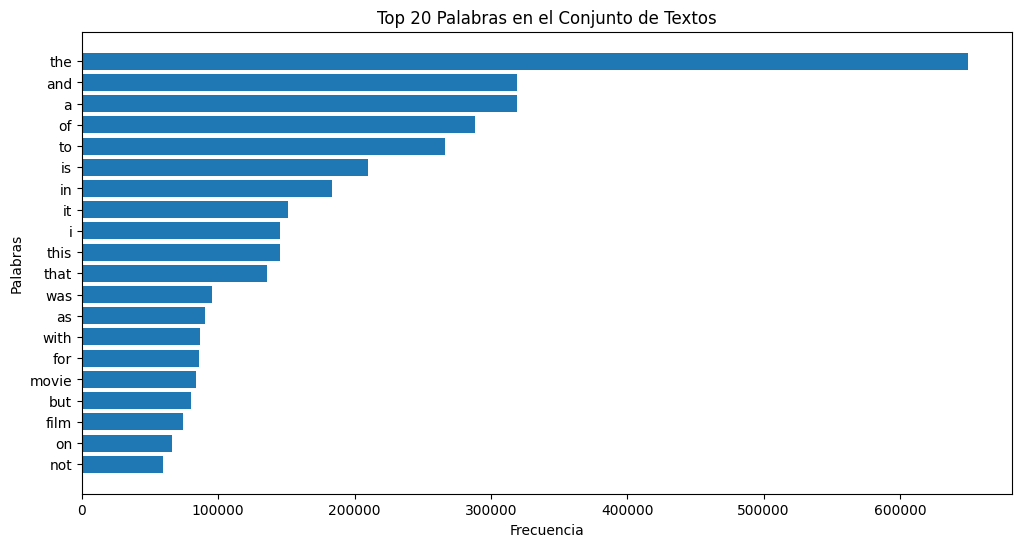

In [25]:
plt.figure(figsize=(12, 6))
plt.barh(words, freq)
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Top 20 Palabras en el Conjunto de Textos')
plt.gca().invert_yaxis() 
plt.show()

## Word2Vec Model

In [26]:
model_word2vec = Word2Vec(tokenized_sentences, vector_size=50, window=10, min_count=10, workers=4)
model_word2vec.train(tokenized_sentences,total_examples=model_word2vec.corpus_count, epochs=20)
model_word2vec.save("./Models/Word2Vec_en")

#### Semantically close words

In [27]:
model_word2vec.wv.most_similar('man')

[('woman', 0.7504264116287231),
 ('soldier', 0.7281051874160767),
 ('boy', 0.7027881145477295),
 ('chap', 0.702273428440094),
 ('guy', 0.6791158318519592),
 ('businessman', 0.6568583846092224),
 ('politician', 0.6497370004653931),
 ('womanizer', 0.6401791572570801),
 ('himself', 0.638550341129303),
 ('person', 0.6356053352355957)]

In [28]:
model_word2vec.wv.most_similar('movie')

[('film', 0.8864319920539856),
 ('movieit', 0.8282526135444641),
 ('filmit', 0.7991085052490234),
 ('it', 0.7703912258148193),
 ('filmbut', 0.7298645973205566),
 ('thing', 0.7289746999740601),
 ('flick', 0.7285234928131104),
 ('moviebut', 0.7227941751480103),
 ('movieand', 0.7067496180534363),
 ('moviethe', 0.6325430870056152)]

In [29]:
model_word2vec.wv.most_similar('director')

[('writerdirector', 0.8305723071098328),
 ('filmmaker', 0.8211217522621155),
 ('curtiz', 0.779025137424469),
 ('screenwriter', 0.7749602198600769),
 ('writer', 0.7671076059341431),
 ('cinematographer', 0.7558705806732178),
 ('directorwriter', 0.714764416217804),
 ('dp', 0.7124712467193604),
 ('altman', 0.7034246921539307),
 ('producer', 0.7003068327903748)]

## Vectorize texts

In [30]:
model_word2vect = Word2Vec.load("./Models/Word2Vec_en")
indexes = model_word2vect.wv.key_to_index

In [31]:
maxlen = 150
max_words = len(indexes)

sequences = vectorice_sentences(tokenized_sentences, indexes)
X = pad_sequences(sequences, maxlen=maxlen)
y = df['sentiment'].apply(lambda x : 1 if x == 'positive' else 0).to_numpy()

## Split dataset into training and test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build embedding matrix

In [33]:
embedding_matrix = np.zeros((max_words, 50))
for word, i in indexes.items():
    if i < max_words:
        if word in indexes:
            embedding_matrix[i] = model_word2vect.wv[word]

## Plot confusion matrix

In [34]:
def plot_confusion_matrix(y_true, y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred) 
    
    fig, ax = plt.subplots(figsize=(3, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.8)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

## Bidirectional LSTM Model

In [35]:
model_lstm = Sequential()
model_lstm.add(Input(shape=(maxlen,)))
model_lstm.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_lstm.add(LSTM(64, return_sequences=True))  
model_lstm.add(LSTM(64, return_sequences=True)) 
model_lstm.add(Flatten())
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid')) 

In [36]:
model_lstm.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           1495650   
                                                                 
 lstm (LSTM)                 (None, 150, 64)           29440     
                                                                 
 lstm_1 (LSTM)               (None, 150, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 64)                614464    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,172,643
Trainable params: 676,993
Non-tr

In [37]:
checkpoint = ModelCheckpoint(
    './Models/model_lstm_en.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_lstm_history = model_lstm.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
250/250 [==============================] - 88s 335ms/step - loss: 0.3740 - accuracy: 0.8302 - recall: 0.8339 - precision: 0.8270 - val_loss: 0.3147 - val_accuracy: 0.8658 - val_recall: 0.8465 - val_precision: 0.8804
Epoch 2/10
250/250 [==============================] - 80s 322ms/step - loss: 0.2845 - accuracy: 0.8804 - recall: 0.8827 - precision: 0.8782 - val_loss: 0.3074 - val_accuracy: 0.8679 - val_recall: 0.9298 - val_precision: 0.8274
Epoch 3/10
250/250 [==============================] - 84s 335ms/step - loss: 0.2375 - accuracy: 0.9016 - recall: 0.9043 - precision: 0.8990 - val_loss: 0.2961 - val_accuracy: 0.8780 - val_recall: 0.8560 - val_precision: 0.8954
Epoch 4/10
250/250 [==============================] - 79s 314ms/step - loss: 0.1877 - accuracy: 0.9243 - recall: 0.9288 - precision: 0.9202 - val_loss: 0.3689 - val_accuracy: 0.8601 - val_recall: 0.7955 - val_precision: 0.9136
Epoch 5/10
250/250 [==============================] - 79s 318ms/step - loss: 0.1325 - accura

In [38]:
model_lstm = load_model("./Models/model_lstm_en.h5")
y_pred_lstm = np.round(model_lstm.predict(X_test).T).astype(int)[0]

313/313 [==============================] - 14s 42ms/step


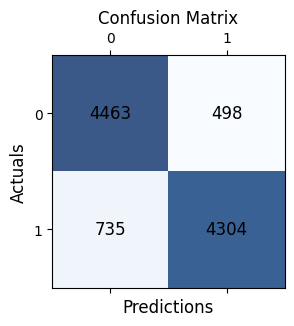

In [39]:
plot_confusion_matrix(y_test, y_pred_lstm)

In [40]:
print(classification_report(y_test,y_pred_lstm))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4961
           1       0.90      0.85      0.87      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Bidirectional GRU Model

In [43]:
model_gru = Sequential()
model_gru.add(Input(shape=(maxlen,)))
model_gru.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_gru.add(GRU(64, return_sequences=True))  
model_gru.add(GRU(64, return_sequences=True)) 
model_gru.add(Flatten())
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid')) 

In [44]:
model_gru.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 50)           1495650   
                                                                 
 gru (GRU)                   (None, 150, 64)           22272     
                                                                 
 gru_1 (GRU)                 (None, 150, 64)           24960     
                                                                 
 flatten_1 (Flatten)         (None, 9600)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                614464    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,157,411
Trainable params: 661,761
Non-

In [45]:
checkpoint = ModelCheckpoint(
    './Models/model_gru_en.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_gru_history = model_gru.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
250/250 [==============================] - 136s 531ms/step - loss: 0.4125 - accuracy: 0.8064 - recall_1: 0.8189 - precision_1: 0.7981 - val_loss: 0.3196 - val_accuracy: 0.8612 - val_recall_1: 0.8610 - val_precision_1: 0.8614
Epoch 2/10
250/250 [==============================] - 130s 520ms/step - loss: 0.2900 - accuracy: 0.8756 - recall_1: 0.8756 - precision_1: 0.8750 - val_loss: 0.3187 - val_accuracy: 0.8640 - val_recall_1: 0.8565 - val_precision_1: 0.8695
Epoch 3/10
250/250 [==============================] - 131s 525ms/step - loss: 0.2223 - accuracy: 0.9092 - recall_1: 0.9100 - precision_1: 0.9081 - val_loss: 0.3353 - val_accuracy: 0.8696 - val_recall_1: 0.9055 - val_precision_1: 0.8449
Epoch 4/10
250/250 [==============================] - 134s 537ms/step - loss: 0.1382 - accuracy: 0.9488 - recall_1: 0.9504 - precision_1: 0.9470 - val_loss: 0.3656 - val_accuracy: 0.8659 - val_recall_1: 0.8410 - val_precision_1: 0.8850
Epoch 5/10
250/250 [==============================] - 12

In [46]:
model_gru = load_model("./Models/model_gru_en.h5")
y_pred_gru = np.round(model_gru.predict(X_test).T).astype(int)[0]

313/313 [==============================] - 11s 34ms/step


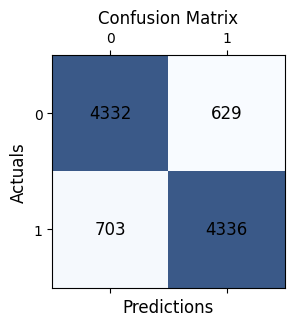

In [47]:
plot_confusion_matrix(y_test, y_pred_gru)

In [48]:
print(classification_report(y_test,y_pred_gru))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      4961
           1       0.87      0.86      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## CNN Model

## Attention Model

## LSTM+Attention Model